# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение. Вам нужно построить модель для определения стоимости авто. 

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.cluster import DBSCAN
import timeit

In [2]:
 df = pd.read_csv('/datasets/autos.csv')

In [3]:
df.columns = [str.lower(x) for x in list(df.columns)]
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
datecrawled          354369 non-null object
price                354369 non-null int64
vehicletype          316879 non-null object
registrationyear     354369 non-null int64
gearbox              334536 non-null object
power                354369 non-null int64
model                334664 non-null object
kilometer            354369 non-null int64
registrationmonth    354369 non-null int64
fueltype             321474 non-null object
brand                354369 non-null object
notrepaired          283215 non-null object
datecreated          354369 non-null object
numberofpictures     354369 non-null int64
postalcode           354369 non-null int64
lastseen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
def fill_nan(df, group, fitch, f = 'freq'):
    '''Заполняет nan значения по выбранной функции и в разрезе групп'''
    if f == 'freq':
        # подставляет максимальную по частоте
        func = lambda s: s.value_counts().idxmax() if len(s.value_counts())>0 else float('Nan')
        df[fitch] = df[fitch].where(~df[fitch].isnull(), df.groupby(group)[fitch].transform(func))
    elif  f == 'mean':   
        # подставляет среднее значение, по не нулевым. Возможно стоит вывести в параметр отбор по 0
        func = lambda s: s.mean()
        df[fitch] = df[fitch].where(~df[fitch].isnull(), df[df[fitch] != 0].groupby(group)[fitch].transform(func))

    
def prov_registr(df, col):
    '''Сравнивает если значение колонок одинаковы, но в разных регистрах'''
    for i in col:
        tmp = df[~df[i].isnull()]
        if tmp[i].apply(lambda x: str.upper(x)).nunique() == tmp[i].nunique():
            print('Колонка '+i +', значения корректны по регистру') 
            
def fill_zero(df, group, col):
    '''Заполняет нулевые числовые колонки средним значением'''
    print("Нулевых записей " + col + " до обработки "+ str(len(df[df[col] == 0])))
    df.loc[df[col] == 0,col] = float('nan') 
    fill_nan(df,group , col, 'mean')
    df[col].fillna(0)
    df[col] = df[col].astype(int)
    print("Нулевых записей " + col + " после обработки "+ str(len(df[df[col] == 0])))

def delete_v(df, col, iscl, group, delete = True):
    '''Автоматически удаляет выбросы по числовым колонкам'''
    cop = df.copy()
    describe = cop.describe()
    if len(col) ==0:
        #по всем
        int_col = cop.columns.values
    else:
        int_col = col
    for i in int_col:
        if cop[i].dtypes == 'object':
            continue
        if i in iscl:
            continue
        if len(group) != 0:
            # квартили с группировкой получаю по другому
            cop['q1'] = df.groupby(group)[i].transform(lambda s: s.describe()['25%'])
            cop['q3'] = df.groupby(group)[i].transform(lambda s: s.describe()['75%'])
            filter_up =  (cop[i] > (cop['q3'] + (cop['q3'] - cop['q1'])*1.5))
            filter_down = (0 < cop[i]) & (cop[i] < (cop['q1'] - (cop['q3'] - cop['q1'])*1.5))
        else:   
            q =  describe[i]
            q1 = q['25%']
            q3 = q['75%']
            mq = q3 - q1
            filter_up =  (cop[i] > (q3 + mq*1.5))
            filter_down = (0 < cop[i]) & (cop[i] < (q1 - mq*1.5))
        if delete:
            cop.loc[filter_up, i] = float('Nan')
            cop.loc[filter_down, i] = float('Nan')
            print('Колонка ' + i + ', изменено '+str(cop[i].isnull().sum())+ ' строк')
        else:
            print('Колонка ' + i + ', должно быть изменено '+ str(cop.loc[filter_up, i].shape[0] + cop.loc[filter_down, i].shape[0])+ ' строк')
        if len(group) != 0:
            cop = cop.drop(['q1', 'q3'] , axis = 1)
        
    if delete:
        print('Всего удалено ' + str(cop.isnull().any(axis=1).sum())+ ' строк')
        cop.dropna(axis=0,inplace=True)
        return cop

def mashtab(x_train, x_test, numeric):
    pd.options.mode.chained_assignment = None
    scaler = StandardScaler()
    scaler.fit(x_train[numeric]) 
    x_train[numeric] = scaler.transform(x_train[numeric])
    x_test[numeric] = scaler.transform(x_test[numeric]) 
    return [x_train, x_test]    


def gridsearch(result, name, type, model, params, new_par, x, y, i = 0 ,scoring = "neg_mean_squared_error"):
    '''перебирает все параметры и ищу лучшую модель. не всегда можно штатными механизмами воспользоваться.'''
    if i < len(params):
        best = {}
        for j in params[list(params.keys())[i]]:
            new_par[list(params.keys())[i]] = j
            gr = gridsearch(result, name, type, model, params, new_par, x, y, i+1)
            if best.get('score') == None:
                best = gr.copy()
            else:
                if best['score'] < np.abs(gr['score']):
                    best['score'] = np.abs(gr['score'])
                    best['model'] = gr['model']
                    best['time_fit'] = gr['time_fit']
        if i == 0:
            result = result.append({'type': type, 'score':np.abs(best['score']) ,'name':name,'model':best['model'],'time_fit':best['time_fit'] }, ignore_index=True)
            return result
        return best
    else:     
        if 'LinearRegression' in name:
            model_obj = model(**new_par)
        else:
            model_obj = model(random_state = 10,**new_par)  
        start_time = timeit.default_timer()
        model_obj.fit(x, y)
        time_fit = timeit.default_timer() - start_time
        return {'score':np.array(cross_val_score(model_obj, x, y, cv=5, scoring = scoring)).mean(),'model':model_obj, 'time_fit': time_fit}
    

In [5]:

prov_registr(df, ['vehicletype','gearbox','model','fueltype','brand','notrepaired'])

Колонка vehicletype, значения корректны по регистру
Колонка gearbox, значения корректны по регистру
Колонка model, значения корректны по регистру
Колонка fueltype, значения корректны по регистру
Колонка brand, значения корректны по регистру
Колонка notrepaired, значения корректны по регистру


In [6]:
# если модель авто не заполнена, то явно некорректно будет восстанавливать значения по бренду, поэтому удаляю
df.dropna(axis=0,inplace=True,subset =['model'])

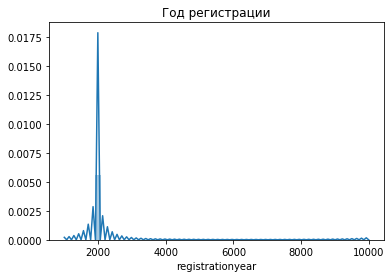

In [7]:
sns.distplot(df['registrationyear'])
plt.title("Год регистрации")
plt.show()
df['date'] = pd.to_datetime(df['lastseen'])
df['year'] =  df['date'].dt.year
df['month'] =  df['date'].dt.month
# дата регистрации может быть неадекватной, это видно из графика.
# данный параметр очень важен, так как от возраста авто очевидно влияет цена
# Если дата регистрации больше даты последней активности пользователя, значит она явно некорретктная, можно удалить запись
mask = (df['registrationyear']>df['year']) | ((df['registrationyear']==df['year']) & (df['registrationmonth']>df['month']))
df.drop(df.iloc[np.where(mask)[0]].index, axis = 0, inplace = True)
# если дата регистрации меньше на 20 лет чем средняя дата по бренду и по модели, то либо это что то уникальное
# либо некорректное. В любом случае можно удалять. 20 лет, потому что на текущий момент средняя время выпуска модели - 7 лет
# Беру с большим запасом. Даже если машина уникальна и долго производилась, должна попасть с большой вероятностью.
df['mean_year'] =  df.groupby(['brand','model'])["registrationyear"].transform('mean')
df.drop(df.iloc[np.where(df['mean_year'] - 20 >df['registrationyear'])[0]].index, axis = 0, inplace = True)

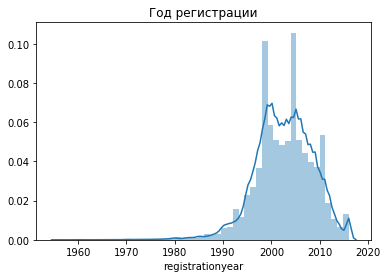

In [8]:
sns.distplot(df['registrationyear'])
plt.title("Год регистрации")
plt.show()

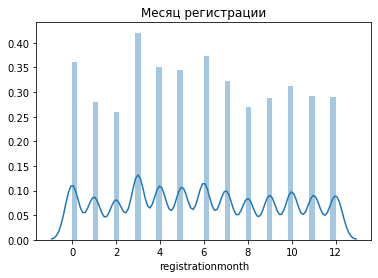

In [9]:
sns.distplot(df['registrationmonth'])
plt.title("Месяц регистрации")
plt.show()
#Есть нулевое значение, но это не так важно. Можно оставить.

In [10]:
   
fill_nan(df,['brand','model'] , 'notrepaired')
fill_nan(df,['brand','model'] , 'vehicletype')
fill_nan(df,['brand','model'] , 'gearbox')
fill_nan(df,['brand','model'] , 'fueltype')

# если что-то не подставилось, то удалить 
df.dropna(inplace = True)

#дату выгрузки лучше перенести в год, так как в разрезе годов цена на одни и те же авто могут ооочень сильно отлличаться
df['date'] = pd.to_datetime(df['datecrawled'])
df['yearcrawled'] =  df['date'].dt.year

# удаляю явно ненужные колокни 
df = df.drop(['mean_year', 'month', 'year', 'date', 'lastseen', 'datecrawled', 'datecreated', 'registrationmonth'] , axis = 1)

In [11]:
#Проверка 0 значения, где они должны быть
fill_zero(df,['brand','model'] ,'power')
fill_zero(df,['brand','model', 'registrationyear'] ,'kilometer')

Нулевых записей power до обработки 29307
Нулевых записей power после обработки 0
Нулевых записей kilometer до обработки 0
Нулевых записей kilometer после обработки 0


In [12]:
# На данном этапе проверяю какие есть выбросы в рамках группировок
# По их количеству будет понятно, удалять записи или нет 
delete_v(df, ['price','kilometer', 'power'],[],['brand','model', 'registrationyear'], False)

Колонка price, должно быть изменено 10566 строк
Колонка kilometer, должно быть изменено 29221 строк
Колонка power, должно быть изменено 22590 строк


In [13]:
# километраж явно больше выбивается. Либо скручивали, либо какие-то ошибки.
# создам таблицу без выбросов. Проверю модели на исходной и этой. 
df_v = delete_v(df, ['price','kilometer', 'power'],[],['brand','model', 'registrationyear'])

Колонка price, изменено 10566 строк
Колонка kilometer, изменено 29221 строк
Колонка power, изменено 22590 строк
Всего удалено 54604 строк


In [14]:
print("Таблица с выбросами")
df.info()
print()
print("Таблица без выбросов")
df_v.info()

Таблица с выбросами
<class 'pandas.core.frame.DataFrame'>
Int64Index: 316052 entries, 0 to 354368
Data columns (total 13 columns):
price               316052 non-null int64
vehicletype         316052 non-null object
registrationyear    316052 non-null int64
gearbox             316052 non-null object
power               316052 non-null int64
model               316052 non-null object
kilometer           316052 non-null int64
fueltype            316052 non-null object
brand               316052 non-null object
notrepaired         316052 non-null object
numberofpictures    316052 non-null int64
postalcode          316052 non-null int64
yearcrawled         316052 non-null int64
dtypes: int64(7), object(6)
memory usage: 33.8+ MB

Таблица без выбросов
<class 'pandas.core.frame.DataFrame'>
Int64Index: 261448 entries, 0 to 354368
Data columns (total 13 columns):
price               261448 non-null float64
vehicletype         261448 non-null object
registrationyear    261448 non-null int64
gear

### Вывод

Была исследована таблица с данными. Данные по колонкам в одинаковом регистре. Удалены незаполненые модели, так как у бренда их может быть много. 

С числовыми данными дела гораздо хуже. Год регистрации бывает больше года последней активности пользователя, что явно некорректно. Также слишком ранние даты. Их немного, поэтому удалил, так как явно год сильно влияет на стоимость авто. 

Сделал таблицу без выбросов. Модели буду проверять на исходной и новой.

## Обучение моделей

In [15]:
result = pd.DataFrame({'score':[],'name':[],'type':[],'model':[],'time_fit':[]})

In [16]:
df_d = pd.get_dummies(df, df.dtypes[df.dtypes == 'object'].index.tolist() , drop_first=True)
df_v_d = pd.get_dummies(df_v, df_v.dtypes[df_v.dtypes == 'object'].index.tolist(), drop_first=True )


In [17]:
x = df_d.drop(['price'], axis=1)
y = df_d['price']


def get_test_train_x_y(x, y, d_test_data, i):
    x_test,  x_train, y_test, y_train = train_test_split(x, y, 
                                                        train_size=0.25, 
                                                        random_state=10, shuffle = True)
    numeric = ['kilometer']
    # Масштабирую значения
    x_train, x_test = mashtab(x_train, x_test,numeric)
    # так как местоположение может очень сильно влиять на цену, то нужно сгруппировать.
    # Идеально группировать по цене, но это целевое значение.
    # можно предположить, что чем богаче район и дороже машины
    # тем больше мощность авто. Поэтому сделайю кластеризацию районов, по медианной мощности машин. 
    dbscan = DBSCAN(eps = 0.2, min_samples = 1)
    x = pd.DataFrame(x_train.groupby('postalcode')['power'].median())
    y = dbscan.fit_predict(x)
    y = pd.DataFrame(pd.Series(y, index = x.index)).reset_index()
    y.columns = ['postalcode', 'gr_postal']
    x_train = pd.merge(x_train, y, on='postalcode', how="left")
    x_train.drop(['postalcode'], axis=1, inplace = True)
    # тестовая
    x = pd.DataFrame(x_test.groupby('postalcode')['power'].median())
    y = dbscan.fit_predict(x)
    y = pd.DataFrame(pd.Series(y, index = x.index)).reset_index()
    y.columns = ['postalcode', 'gr_postal']
    x_test = pd.merge(x_test, y, on='postalcode', how="left")    
    
    # удалить у кого корреляция больше 0.75
    corr_matrix = x_train.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] >= 0.75)] 
    x_train.drop(to_drop, axis=1, inplace = True)
    
    # удаляю ненужные колонки
    set_train = set(x_train.columns)
    set_test = set(x_test.columns)
    x_test.drop(list(set_test.difference(set_train)) , axis = 1, inplace = True)
    d_test_data[i] = [x_test, y_test]
    return [x_train, x_test, y_train, y_test]
d_test_data = {}    
x_train, x_test, y_train, y_test = get_test_train_x_y(x, y, d_test_data, 1)

# Наборы без выбросов
x = df_v_d.drop(['price'], axis=1)
y = df_v_d['price']
x_v_train, x_v_test, y_v_train, y_v_test = get_test_train_x_y(x, y, d_test_data, 2)

# Наборы без выбросов, где категориальные переменные обрабатываются самим регрессором
df_ = df_v.copy()
for c in df_.dtypes[df_.dtypes == 'object'].index.tolist():
    df_[c] = df_[c].astype('category')

x = df_.drop(['price'], axis=1)
y = df_['price']
x_v_kat_train, x_v_kat_test, y_v_kat_train, y_v_kat_test = get_test_train_x_y(x, y, d_test_data, 3)

# Наборы с выбросами, где категориальные переменные обрабатываются самим регрессором
df_ = df.copy()
for c in df_.dtypes[df_.dtypes == 'object'].index.tolist():
    df_[c] = df_[c].astype('category')

x = df_.drop(['price'], axis=1)
y = df_['price']
x_kat_train, x_kat_test, y_kat_train, y_kat_test = get_test_train_x_y(x, y, d_test_data, 4)



In [18]:
%%time
# очень долго делается, иногда возникает сообщение, что ядро не отвечает, всё заново
# но выдавал самые лучшие результаты
#param_grid = {
#    # 'max_depth': range(4,7) ,
#    'n_estimators': [50, 100, 200] }

#result = gridsearch(result, 'RandomForestRegressor (С выбросами)',RandomForestRegressor, param_grid, {}, x_train, y_train)
#result = gridsearch(result, 'RandomForestRegressor (Без выбросов)',RandomForestRegressor, param_grid, {}, x_v_train, y_v_train)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.3 µs


In [19]:
param_grid = {'max_depth': range(4,7),
             'learning_rate': [0.001, 0.01, 0.1]} 
result = gridsearch(result, 'LGBMRegressor (С выбросами)', 1,LGBMRegressor, param_grid, {}, x_train, y_train)
result = gridsearch(result, 'LGBMRegressor (Без выбросов)', 2,LGBMRegressor, param_grid, {}, x_v_train, y_v_train)

In [20]:
param_grid = {'fit_intercept': [True]}
result = gridsearch(result, 'LinearRegression (С выбросами)', 1, LinearRegression, param_grid, {}, x_train, y_train)
result = gridsearch(result, 'LinearRegression (Без выбросов)', 2, LinearRegression, param_grid, {}, x_v_train, y_v_train)

In [21]:
param_grid = {'max_depth': range(4,7),
             'learning_rate': [0.001, 0.01, 0.1]} 
result = gridsearch(result, 'LGBMRegressor (С выбросами, без OHE)', 4,LGBMRegressor, param_grid, {}, x_kat_train, y_kat_train)
result = gridsearch(result, 'LGBMRegressor (Без выбросов, без OHE)', 3,LGBMRegressor, param_grid, {}, x_v_kat_train, y_v_kat_train)

In [22]:
result

,score,name,type,model,time_fit
0,7.919367e+06,LGBMRegressor (С выбросами),1.0,"LGBMRegressor(boosting_type='gbdt', class_weig...",10.187693
1,6.950131e+06,LGBMRegressor (Без выбросов),2.0,"LGBMRegressor(boosting_type='gbdt', class_weig...",11.189311
2,2.828902e+09,LinearRegression (С выбросами),1.0,"LinearRegression(copy_X=True, fit_intercept=Tr...",25.478490
3,5.725829e+06,LinearRegression (Без выбросов),2.0,"LinearRegression(copy_X=True, fit_intercept=Tr...",19.695729
4,7.610115e+06,"LGBMRegressor (С выбросами, без OHE)",4.0,"LGBMRegressor(boosting_type='gbdt', class_weig...",100.007705
5,6.612491e+06,"LGBMRegressor (Без выбросов, без OHE)",3.0,"LGBMRegressor(boosting_type='gbdt', class_weig...",6.101556


### Вывод

Были обучены 3 модели, каждая на 2х датасетах. Обычная линейная регрессия и регресии c градиентным бустингом. Ещё модель на случайном лесе на тестовых данных давала наилучшие результаты, но считалась не менее 4 часов, и не всегда, поэтому я не стал её сюда добавлять.

Категориальные переменные были преобразованы в числовые по OHE, для одной модели такие переменные отрабатывались в самой модели. Километраж мог сильно варьироваться, поэтому его масштабировал. Районы по почтовому индексу кластеризировал по мощности мотора, исходя из предположения, что более мощные машины более дорогие, а значит сконцетрированы в более хороших районах. Также удалены коррелирующие столбцы.

## Анализ моделей

In [23]:
def get_xy(type, x):
    if x:       
        if type == 1:
            return x_test
        elif type == 2:
            return x_v_test
        elif type == 3:
            return x_v_kat_test
        elif type == 4:
            return x_kat_test
    else:
        if type == 1:
            return pd.DataFrame(y_test)
        elif type == 2:
            return pd.DataFrame(y_v_test)
        elif type == 3:
            return pd.DataFrame(y_v_kat_test)
        elif type == 4:
            return pd.DataFrame(y_kat_test) 

result['x_'] = result.apply(lambda x: get_xy(x['type'], True), axis=1)
result['y_'] = result.apply(lambda x: get_xy(x['type'], False), axis=1)
result['time_predict'] = 0

d = {}
def predict(x,d):
    start_time = timeit.default_timer()
    s = x.model.predict(x.x_)
    d[x.name] = timeit.default_timer() - start_time
    return s
result['predict'] = result.apply(lambda x: predict(x,d), axis=1)

for i in d.keys():
    result.loc[i,'time_predict'] = d[i]
    
result['y_score'] = result.apply(lambda x:  mean_squared_error(x.predict, x.y_)**0.5 , axis=1)
result= result.sort_values(by = 'y_score', ascending = True)

display(result[['name', 'y_score', 'time_predict', 'time_fit']])

d = DummyRegressor(strategy="mean")
d.fit(x_train, y_train)
print('RMSE простой модель для данных с выбросами:', mean_squared_error(d.predict(x_test), y_test)**0.5)

d = DummyRegressor(strategy="mean")
d.fit(x_v_train, y_v_train)
print('RMSE простой модель для данных без выбросов:', mean_squared_error(d.predict(x_v_test), y_v_test)**0.5)


,name,y_score,time_predict,time_fit
3,LinearRegression (Без выбросов),2384.709690,0.279421,19.695729
5,"LGBMRegressor (Без выбросов, без OHE)",2578.872444,0.506176,6.101556
1,LGBMRegressor (Без выбросов),2649.475801,0.784965,11.189311
2,LinearRegression (С выбросами),2725.326726,0.117135,25.478490
4,"LGBMRegressor (С выбросами, без OHE)",2738.112222,0.797876,100.007705
0,LGBMRegressor (С выбросами),2795.717612,0.817397,10.187693


RMSE простой модель для данных с выбросами: 4548.592318669816
RMSE простой модель для данных без выбросов: 4488.435405719058


### Вывод

Обычная линейная регрессия на данных без выбросов показала наилучший результат. 

По скорости обучения LGBM был быстрее если категориальные переменные обрабатывать в самой модели и без выбросов. Если через OHE, то не быстрее лиенейно регресии. По скорости предсказания - линейная регрессия самая быстрая чего и стоило ожидать.

Любая модель показала гораздо лучший результат по сравнению с дамми моделью, что хорошо.